This colab contains various data augmentation and generalization techniques

- l1 l2

- dropout

- earlystop

- montecarlo dropout

- various initializations and when to use what

- batch normalization

- custsom dropout, custom regularization

Import statements

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


###Vanishing/Exploding Gradients problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


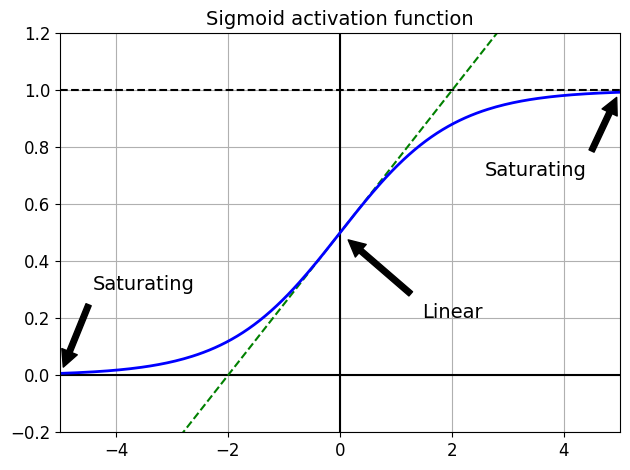

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [4]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [5]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)


###Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

###Non Saturating Activation Functions

Leaky Relu

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


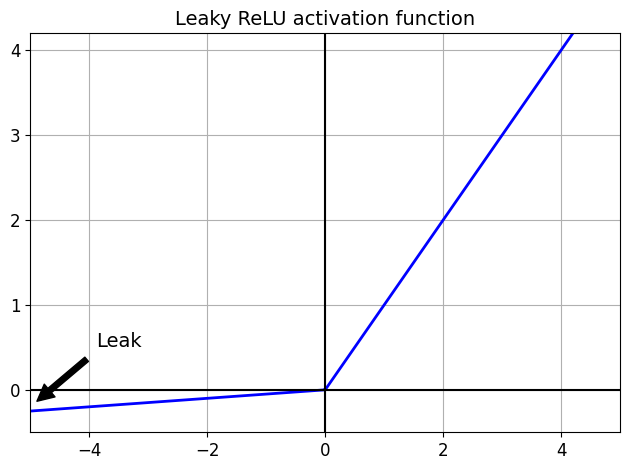

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Train Network on Fashion MNISt using leaky Relu

In [10]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [11]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.2911 - accuracy: 0.6153 - val_loss: 0.8677 - val_accuracy: 0.7192
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7875 - accuracy: 0.7375 - val_loss: 0.7025 - val_accuracy: 0.7668
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6788 - accuracy: 0.7735 - val_loss: 0.6390 - val_accuracy: 0.7944
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6203 - accuracy: 0.7936 - val_loss: 0.5843 - val_accuracy: 0.8114
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5823 - accuracy: 0.8044 - val_loss: 0.5541 - val_accuracy: 0.8222
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5550 - accuracy: 0.8122 - val_loss: 0.5320 - val_accuracy: 0.8264
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5343 - accuracy: 0.8190 - val_loss: 0.5131 - val_accurac

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.2711 - accuracy: 0.6345 - val_loss: 0.8621 - val_accuracy: 0.7356
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7807 - accuracy: 0.7573 - val_loss: 0.6914 - val_accuracy: 0.7776
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6673 - accuracy: 0.7880 - val_loss: 0.6258 - val_accuracy: 0.8036
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6090 - accuracy: 0.8034 - val_loss: 0.5708 - val_accuracy: 0.8182
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5718 - accuracy: 0.8123 - val_loss: 0.5405 - val_accuracy: 0.8256
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5454 - accuracy: 0.8182 - val_loss: 0.5188 - val_accuracy: 0.8312
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5255 - accuracy: 0.8238 - val_loss: 0.5001 - val_accurac

ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:


In [17]:

dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

SELU

In [18]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [20]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


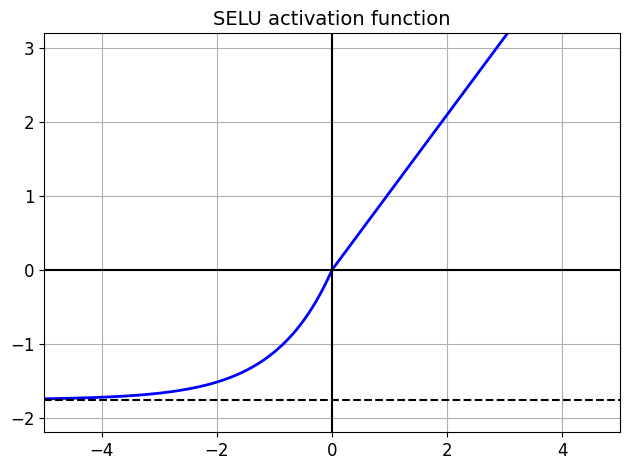

In [21]:

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

Saving figure elu_selu_plot


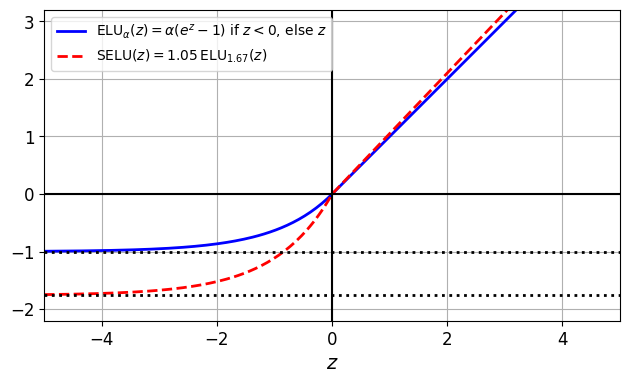

In [22]:
z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

In [23]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using Selu on Fashion MNISt data

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))


In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Train model. Scale data with mean 0 and standard deviation 1

In [27]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 47s 23ms/step - loss: 0.9790 - accuracy: 0.6412 - val_loss: 0.7285 - val_accuracy: 0.7502
Epoch 2/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.6602 - accuracy: 0.7601 - val_loss: 1.4688 - val_accuracy: 0.4992
Epoch 3/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.6423 - accuracy: 0.7697 - val_loss: 0.5709 - val_accuracy: 0.7980
Epoch 4/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5052 - accuracy: 0.8214 - val_loss: 0.4653 - val_accuracy: 0.8342
Epoch 5/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.4621 - accuracy: 0.8371 - val_loss: 0.4384 - val_accuracy: 0.8476


###Batch Normalization

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_112 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_113 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

In [30]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [31]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [33]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8784 - accuracy: 0.7053 - val_loss: 0.5765 - val_accuracy: 0.8058
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5872 - accuracy: 0.7967 - val_loss: 0.4946 - val_accuracy: 0.8344
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5309 - accuracy: 0.8148 - val_loss: 0.4572 - val_accuracy: 0.8462
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4884 - accuracy: 0.8295 - val_loss: 0.4363 - val_accuracy: 0.8508
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4626 - accuracy: 0.8374 - val_loss: 0.4195 - val_accuracy: 0.8558
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4459 - accuracy: 0.8422 - val_loss: 0.4064 - val_accuracy: 0.8612
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4315 - accuracy: 0.8489 - val_loss: 0.3959 - val_ac

###A/B testing

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [34]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

NameError: name 'class_names' is not defined

###Optimizers

Momentum Optimization

In [35]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

Nesterov Accelerated Gradient

In [36]:

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

AdaGrad

In [37]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)


Adam Optimization

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Adamax Optimization

In [39]:

optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Learning Rate Scheduling

In [40]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [43]:
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3761 - accuracy: 0.8665 - val_loss: 0.3721 - val_accuracy: 0.8664
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3454 - accuracy: 0.8771 - val_loss: 0.3568 - val_accuracy: 0.8746
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3244 - accuracy: 0.8842 - val_loss: 0.3605 - val_accuracy: 0.8744
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3087 - accuracy: 0.8890 - val_loss: 0.3436 - val_accuracy: 0.8810
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2971 - accuracy: 0.8937 - val_loss: 0.3362 - val_accuracy: 0.8820
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2858 - accuracy: 0.8974 - val_loss: 0.3366 - val_accuracy: 0.8822
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2772 - accuracy: 0.9011 - val_loss: 0.3317 - val_accura

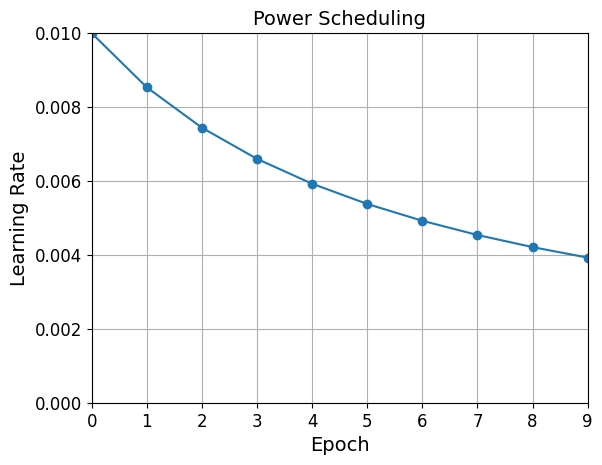

In [44]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Exponential Scheduling

In [45]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [46]:

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [51]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 10

In [52]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7230 - accuracy: 0.7851 - val_loss: 0.6510 - val_accuracy: 0.8162 - lr: 0.0100
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6105 - accuracy: 0.8123 - val_loss: 0.5990 - val_accuracy: 0.8074 - lr: 0.0089
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5986 - accuracy: 0.8184 - val_loss: 0.8447 - val_accuracy: 0.7526 - lr: 0.0079
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5633 - accuracy: 0.8305 - val_loss: 0.5680 - val_accuracy: 0.8322 - lr: 0.0071
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5073 - accuracy: 0.8458 - val_loss: 0.5185 - val_accuracy: 0.8572 - lr: 0.0063
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4379 - accuracy: 0.8609 - val_loss: 0.5732 - val_accuracy: 0.8482 - lr: 0.0056
Epoch 7/10
1719/1719 [==============================

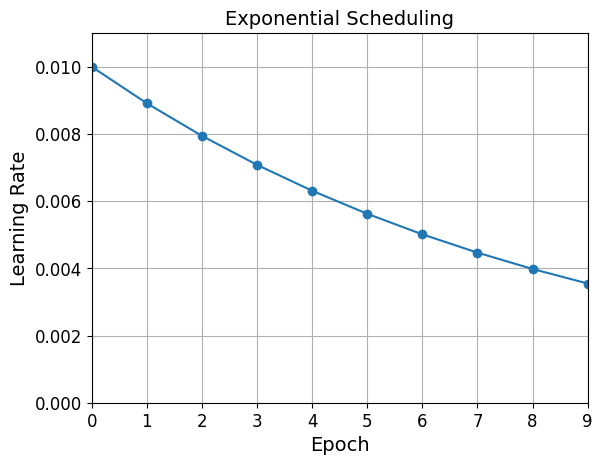

In [53]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Piecewise Constant Scheduling

In [54]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [55]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [57]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 21s 9ms/step - loss: 0.7387 - accuracy: 0.7808 - val_loss: 0.5863 - val_accuracy: 0.8342 - lr: 0.0100
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7736 - accuracy: 0.7686 - val_loss: 0.6717 - val_accuracy: 0.7956 - lr: 0.0100
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7945 - accuracy: 0.7648 - val_loss: 0.8963 - val_accuracy: 0.7462 - lr: 0.0100
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7722 - accuracy: 0.7698 - val_loss: 1.0425 - val_accuracy: 0.6624 - lr: 0.0100
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.8777 - accuracy: 0.7408 - val_loss: 0.8161 - val_accuracy: 0.7364 - lr: 0.0100
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5363 - accuracy: 0.8289 - val_loss: 0.5579 - val_accuracy: 0.8412 - lr: 0.0050
Epoch 7/10
1719/1719 [==============================

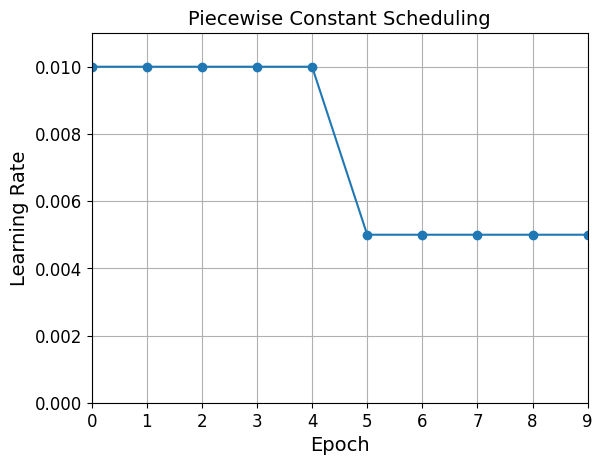

In [58]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Performance Scheduling

In [59]:
tf.random.set_seed(42)
np.random.seed(42)


In [60]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5930 - accuracy: 0.8074 - val_loss: 0.4733 - val_accuracy: 0.8534 - lr: 0.0200
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4922 - accuracy: 0.8402 - val_loss: 0.6154 - val_accuracy: 0.8298 - lr: 0.0200
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5355 - accuracy: 0.8393 - val_loss: 0.4949 - val_accuracy: 0.8522 - lr: 0.0200
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5067 - accuracy: 0.8486 - val_loss: 0.5119 - val_accuracy: 0.8576 - lr: 0.0200
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5170 - accuracy: 0.8497 - val_loss: 0.5250 - val_accuracy: 0.8396 - lr: 0.0200
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5084 - accuracy: 0.8534 - val_loss: 0.5041 - val_accuracy: 0.8572 - lr: 0.0200
Epoch 7/10
1719/1719 [==============================] - 8

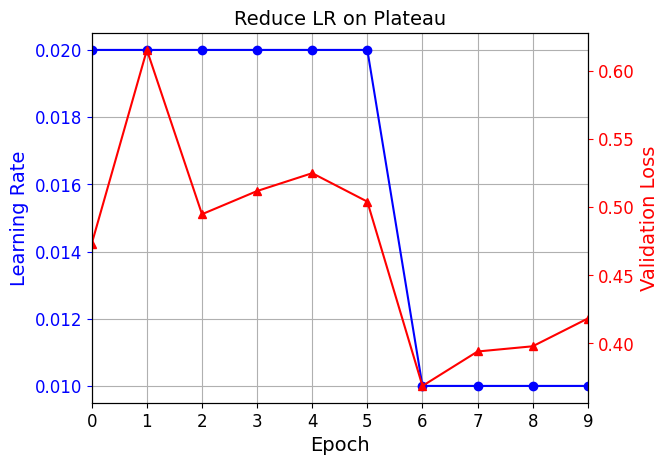

In [61]:

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

Keras scheduler

In [62]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4876 - accuracy: 0.8296 - val_loss: 0.3955 - val_accuracy: 0.8638
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3769 - accuracy: 0.8664 - val_loss: 0.3648 - val_accuracy: 0.8684
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3432 - accuracy: 0.8787 - val_loss: 0.3645 - val_accuracy: 0.8704
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3215 - accuracy: 0.8853 - val_loss: 0.3438 - val_accuracy: 0.8772
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3059 - accuracy: 0.8909 - val_loss: 0.3380 - val_accuracy: 0.8786
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2914 - accuracy: 0.8959 - val_loss: 0.3362 - val_accuracy: 0.8836
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2809 - accuracy: 0.8998 - val_loss: 0.3301 - val_accuracy:

In [63]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

1Cycle Scheduling

In [64]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


430/430 [==============================] - 4s 7ms/step - loss: nan - accuracy: 0.3592


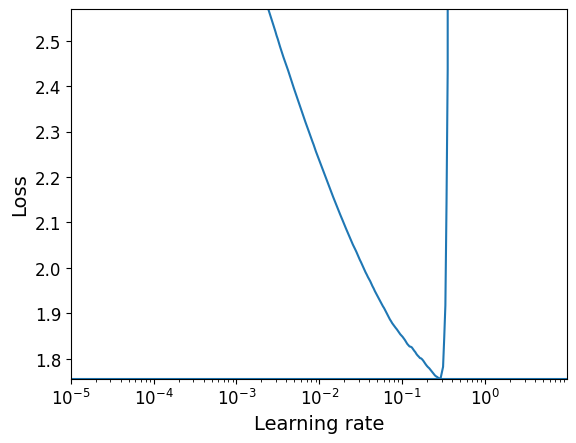

In [66]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)


Avoid overfitting Through Regularization

###l1 and l2 regularization

In [67]:
layer = keras.layers.Dense(100, activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [68]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="relu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 1.4913 - accuracy: 0.8172 - val_loss: 0.7173 - val_accuracy: 0.8424
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7291 - accuracy: 0.8313 - val_loss: 0.7102 - val_accuracy: 0.8324


In [69]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 7ms/step - loss: 1.6329 - accuracy: 0.8149 - val_loss: 0.7075 - val_accuracy: 0.8372
Epoch 2/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7204 - accuracy: 0.8277 - val_loss: 0.6956 - val_accuracy: 0.8328


###Dropout

In [70]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 26s 8ms/step - loss: 0.5724 - accuracy: 0.8045 - val_loss: 0.3609 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4217 - accuracy: 0.8449 - val_loss: 0.3493 - val_accuracy: 0.8698


###Alpha Dropout

In [71]:
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6640 - accuracy: 0.7581 - val_loss: 0.6016 - val_accuracy: 0.8400
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5610 - accuracy: 0.7940 - val_loss: 0.5633 - val_accuracy: 0.8498
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5276 - accuracy: 0.8037 - val_loss: 0.5120 - val_accuracy: 0.8482
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5096 - accuracy: 0.8112 - val_loss: 0.4709 - val_accuracy: 0.8626
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4932 - accuracy: 0.8170 - val_loss: 0.4850 - val_accuracy: 0.8596
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4830 - accuracy: 0.8196 - val_loss: 0.4835 - val_accuracy: 0.8602
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4700 - accuracy: 0.8273 - val_loss: 0.4749 - val_accuracy:

In [72]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3297 - accuracy: 0.8731


[0.3296983242034912, 0.8731091022491455]

In [73]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3926 - accuracy: 0.8551


[0.3925583064556122, 0.8550999760627747]

In [74]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 14s 8ms/step - loss: 0.3479 - accuracy: 0.8694


###MonteCarlo Dropout

In [75]:
tf.random.set_seed(42)
np.random.seed(42)

In [76]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


In [77]:
np.round(model.predict(X_test_scaled[:1]), 2)
np.round(y_probas[:, :1], 2)
np.round(y_proba[:1], 2)

1/1 [==============================] - 0s 125ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.35, 0.  , 0.48]],
      dtype=float32)

In [78]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.3 , 0.  , 0.3 ]],
      dtype=float32)

In [79]:
y_pred = np.argmax(y_proba, axis=1)

In [80]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8608

In [81]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [82]:
tf.random.set_seed(42)
np.random.seed(42)


In [83]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])
mc_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_146 (Dense)           (None, 300)               235500    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_147 (Dense)           (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_148 (Dense)           (None, 10)              

In [84]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [85]:

mc_model.set_weights(model.get_weights())
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 20ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.27, 0.  , 0.62]],
      dtype=float32)

###Max Norm

In [86]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [87]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 20s 11ms/step - loss: 0.4791 - accuracy: 0.8336 - val_loss: 0.3811 - val_accuracy: 0.8630
Epoch 2/2
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3595 - accuracy: 0.8694 - val_loss: 0.4058 - val_accuracy: 0.8586


# early_stopping

In [88]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

In [89]:
# Load data into a DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert datatype to float
df = df.astype(float)
# append "target" and name it "label"
df['label'] = iris.target
# Use string label instead
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

In [90]:
# label -> one-hot encoding
label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
# drop old label
df.drop(['label'], axis=1, inplace=True)

In [91]:
# Creating X and y
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
# Convert DataFrame into np array
X = np.asarray(X)
y= df[['label_setosa', 'label_versicolor', 'label_virginica']]
# Convert DataFrame into np array
y = np.asarray(y)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(4,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

In [94]:
model = create_model()

In [95]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [96]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.25,
    batch_size=40,
    verbose=2
)

Epoch 1/200
3/3 - 2s - loss: 1.0807 - accuracy: 0.5222 - val_loss: 1.0430 - val_accuracy: 0.6000 - 2s/epoch - 778ms/step
Epoch 2/200
3/3 - 0s - loss: 1.0136 - accuracy: 0.7000 - val_loss: 0.9561 - val_accuracy: 0.9667 - 79ms/epoch - 26ms/step
Epoch 3/200
3/3 - 0s - loss: 0.9210 - accuracy: 0.8111 - val_loss: 0.8547 - val_accuracy: 0.6333 - 76ms/epoch - 25ms/step
Epoch 4/200
3/3 - 0s - loss: 0.7989 - accuracy: 0.6667 - val_loss: 0.7266 - val_accuracy: 0.6667 - 79ms/epoch - 26ms/step
Epoch 5/200
3/3 - 0s - loss: 0.6585 - accuracy: 0.7222 - val_loss: 0.5972 - val_accuracy: 0.8667 - 90ms/epoch - 30ms/step
Epoch 6/200
3/3 - 0s - loss: 0.5196 - accuracy: 0.8556 - val_loss: 0.4790 - val_accuracy: 0.9333 - 80ms/epoch - 27ms/step
Epoch 7/200
3/3 - 0s - loss: 0.4075 - accuracy: 0.9444 - val_loss: 0.3904 - val_accuracy: 0.9333 - 83ms/epoch - 28ms/step
Epoch 8/200
3/3 - 0s - loss: 0.3385 - accuracy: 0.9222 - val_loss: 0.3160 - val_accuracy: 1.0000 - 81ms/epoch - 27ms/step
Epoch 9/200
3/3 - 0s - lo

In [97]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

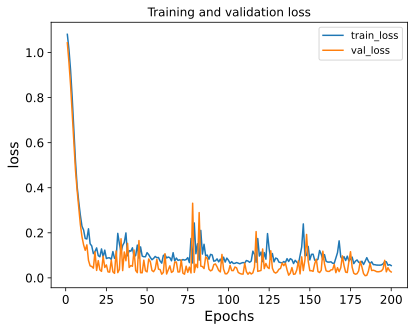

In [98]:
plot_metric(history, 'loss')

In [99]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [100]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.25,
    batch_size=40,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/200
3/3 - 0s - loss: 0.0583 - accuracy: 0.9778 - val_loss: 0.0253 - val_accuracy: 1.0000 - 110ms/epoch - 37ms/step
Epoch 2/200
3/3 - 0s - loss: 0.0552 - accuracy: 0.9889 - val_loss: 0.0406 - val_accuracy: 0.9667 - 75ms/epoch - 25ms/step


In [101]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    min_delta=0.001,
    mode='max'
)

In [102]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.25,
    batch_size=40,
    verbose=2,
    callbacks=[custom_early_stopping]
)

Epoch 1/200
3/3 - 0s - loss: 0.0619 - accuracy: 0.9778 - val_loss: 0.0263 - val_accuracy: 1.0000 - 331ms/epoch - 110ms/step
Epoch 2/200
3/3 - 0s - loss: 0.0553 - accuracy: 0.9889 - val_loss: 0.0389 - val_accuracy: 1.0000 - 134ms/epoch - 45ms/step
Epoch 3/200
3/3 - 0s - loss: 0.0613 - accuracy: 0.9778 - val_loss: 0.0318 - val_accuracy: 1.0000 - 128ms/epoch - 43ms/step
Epoch 4/200
3/3 - 0s - loss: 0.0580 - accuracy: 0.9889 - val_loss: 0.0789 - val_accuracy: 0.9667 - 106ms/epoch - 35ms/step
Epoch 5/200
3/3 - 0s - loss: 0.0647 - accuracy: 0.9667 - val_loss: 0.0244 - val_accuracy: 1.0000 - 119ms/epoch - 40ms/step
Epoch 6/200
3/3 - 0s - loss: 0.0604 - accuracy: 0.9778 - val_loss: 0.0138 - val_accuracy: 1.0000 - 184ms/epoch - 61ms/step
Epoch 7/200
3/3 - 0s - loss: 0.0658 - accuracy: 0.9667 - val_loss: 0.0517 - val_accuracy: 0.9667 - 118ms/epoch - 39ms/step
Epoch 8/200
3/3 - 0s - loss: 0.0700 - accuracy: 0.9667 - val_loss: 0.0871 - val_accuracy: 0.9667 - 133ms/epoch - 44ms/step
Epoch 9/200
3/3

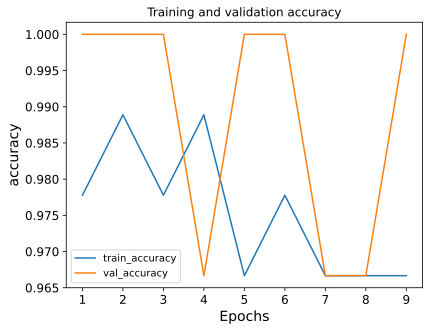

In [103]:
plot_metric(history, 'accuracy')